<a href="https://colab.research.google.com/github/Bhavya171/LLM_From_Scratch/blob/main/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4

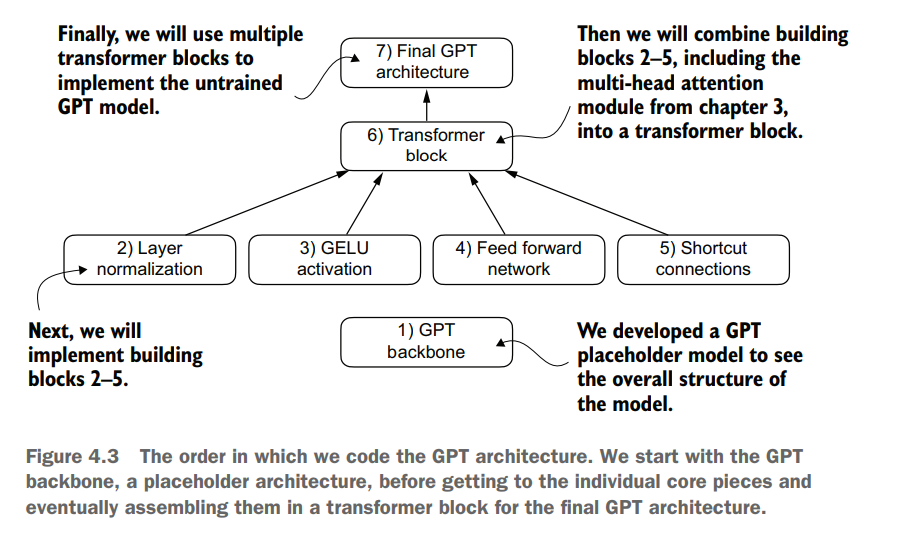

In [ ]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

In the GPT_CONFIG_124M dictionary, we use concise variable names for clarity and to
prevent long lines of code:
  

1.   **vocab_size** refers to a vocabulary of 50,257 words, as used by the BPE tokenizer
(see chapter 2).
2.   **context_length** denotes the maximum number of input tokens the model can
handle via the positional embeddings (see chapter 2).
3.   **emb_dim** represents the embedding size, transforming each token into a 768-
dimensional vector.
4.  **n_heads** indicates the count of attention heads in the multi-head attention
mechanism (see chapter 3).
5.  **n_layers** specifies the number of transformer blocks in the model, which we
will cover in the upcoming discussion.
6.  **drop_rate** indicates the intensity of the dropout mechanism (0.1 implies a 10%
random drop out of hidden units) to prevent overfitting (see chapter 3).
7.  **qkv_bias** determines whether to include a bias vector in the Linear layers of
the multi-head attention for query, key, and value computations. We will initially
disable this, following the norms of modern LLMs, but we will revisit it in chapter 6 when we load pretrained GPT-2 weights from OpenAI into our model (see
chapter 6).

## 1)  GPT backbone the DummyGPTModel

In [ ]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg)
        for _ in range(cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
    cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device = in_idx.device)
    )

    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):   # To be replaced by real Transformer Block later
    super().__init__()

  def forward(self,x): # does nothing
    return x


class DummyLayerNorm(nn.Module):
  def __init__(self,normalised_shape, eps = 1e-5):
    super().__init__() # to be replaced by LayerNorm later

  def forward(self,x): # same as above
    return x


In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim = 0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
# initializing a new 124-M-parameter DummyGPTModel and feeding it
# tokenised batch:

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits.shape)
print(logits)

torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 2) Normalisation

Main idea behind Normalisation is to adjust the outputs in such a way that their mean is 0 and variance is 1 because this normalisations speeds up the convergence to effective weighs and ensures consistent, reliable training.

This is mainly applied before and after the multi-head attention module as done above.

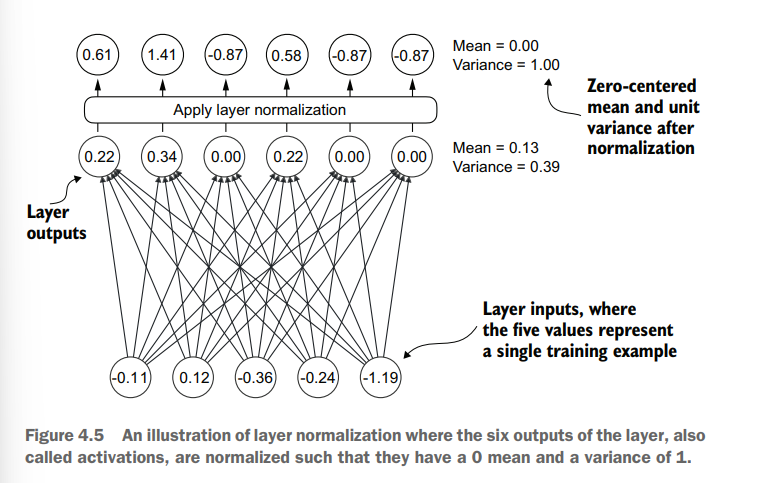

In [ ]:
# recreating this example

torch.manual_seed(123)
batch_example = torch.rand(2,5) # 2 rows 5 dimensional each
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
# calculating the mean and variances for the same

mean = out.mean(dim = -1, keepdim = True) # keepdim is for keeping the dim same of the input and the output
variance = out.var(dim = -1, keepdim = True) # dim parameter => dim = 0 => operations to be done vertically
                                            # dim = 1 or -1 => operations to be done horizontally
print(mean)
print(variance)

tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [ ]:
# applying normalisation to the outputs we got
# basic formula is to subtract the mean and divide by std

out_norm = (out - mean) / torch.sqrt(variance)
mean = out_norm.mean(dim = -1, keepdim = True)
var = out_norm.var(dim = -1, keepdim = True)

print("normalised: ", out_norm)
print("mean: ", mean)
print("var: ", var)

normalised:  tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
mean:  tensor([[ 5.9605e-08],
        [-4.9671e-08]], grad_fn=<MeanBackward1>)
var:  tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


Note that mean is almost 0 for both the outputs and var is 1 for both.

=> The results are normalised

In [ ]:
# a layer normalisation class

class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5 # small constant for preventing division by zero
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))


  def forward(self,x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    norm_x = (x - mean)/ torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift
    # see this as m * x + b where m is scaling factor and b is the shifting factor


In [ ]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, keepdim = True, unbiased = False)

print(mean)
print(var)

tensor([[ 2.3842e-08],
        [-9.5367e-08]], grad_fn=<MeanBackward1>)
tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


## 3-4) Feed Forward Network with GELU activation function

GELU = x.phi(x) where phi(x) is cummulative distribution function of gaussian distribution.

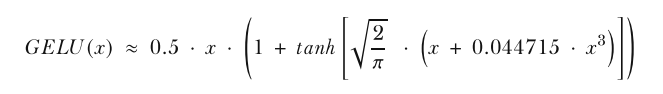

In [ ]:
# Implementing GELU in pytorch

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1 + torch.tanh(
    torch.sqrt(torch.tensor(2.0 / torch.pi)) *
    (x + 0.044715 * torch.pow(x, 3))
    ))

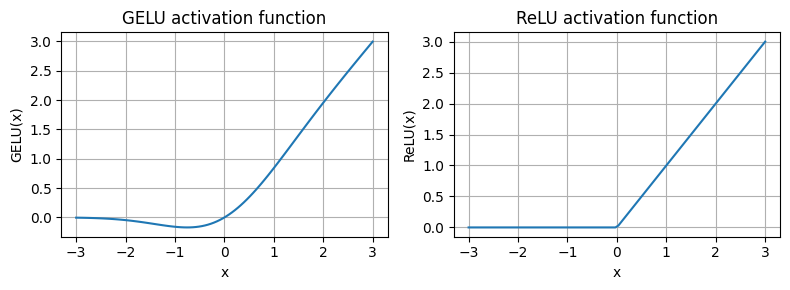

In [ ]:
# plotting ReLU and GELU side by side

import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)
plt.tight_layout()
plt.show()

Notice that ReLU is linearly positive or zero but GELU is smooth, nonlinear the approximates relu but with a non zero gradient for almost all negative values.

This smoothness can lead to better optimisation properties during training.

In [ ]:
# using GELU in a small neural network module, FeedForward

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self,x):
    return self.layers(x)



In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2 , 3 , 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## 5) Shortcut connections

Shortcut connections were inntroduced in Computer Vision to mitigate the problem of vanishing gradients. Vanishing gradients was a problem in which the gradient becomes progressively smaller as they propagate backward through the layers.



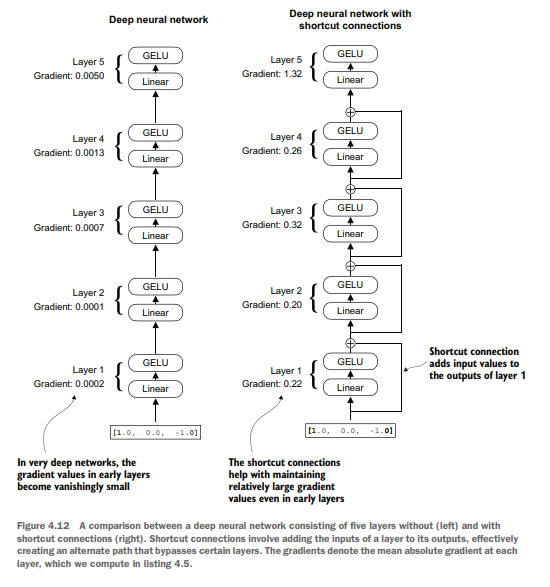

In [ ]:
# a neural network class to implement shortcut connections

class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self,layer_sizes,use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
            GELU())
    ])


  def forward(self,x):
    for layer in self.layers:
        layer_output = layer(x)
        if self.use_shortcut and x.shape == layer_output.shape:
          x = x * layer_output
        else:
          x = layer_output

    return x

In [ ]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1. , 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut = False
)

In [ ]:
# function that computes the gradients in the model's backward pass

def print_gradients(model,x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output,target)

  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


This shows that gradient decreases from last layer to first layer( layer 4 to 1)

This is call vanishing gradient problem.


In [ ]:
# implementing with shortcuts

torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes , use_shortcut = True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 1.9702974896063097e-06
layers.1.0.weight has gradient mean of 2.4566793399571907e-07
layers.2.0.weight has gradient mean of 4.4787462627482455e-08
layers.3.0.weight has gradient mean of 3.956091454426769e-09
layers.4.0.weight has gradient mean of 1.7112864725277177e-06


## 6) Transformer block
Connecting all the subsections now

This block, which is repeated a dozen times in the 124-millionparameter GPT-2 architecture, combines several concepts we have previously covered:
multi-head attention, layer normalization, dropout, feed forward layers, and GELU
activations

In [ ]:
# transformer block in code

# run the chapter 3 code for MultiHeadAttention class

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]
    )
    self.ff  = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])


  def forward(self,x):

    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x



In [ ]:
torch.manual_seed(123)
x = torch.rand(2,5,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("input: ", x.shape)
print("output: ", output.shape)

input:  torch.Size([2, 5, 768])
output:  torch.Size([2, 5, 768])


it is crucial to keep the shape same throughout.

## 7) Coding the GPT model


The basic architecture which we will code

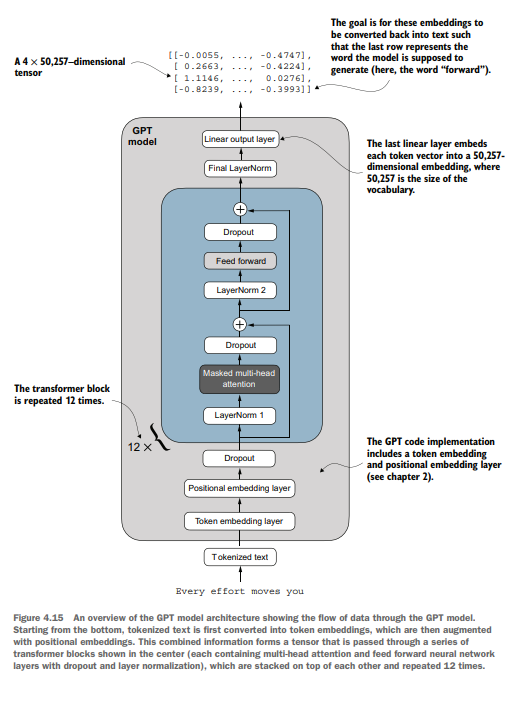

In [ ]:
# coding the architecture

class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(
        cfg['emb_dim'], cfg['vocab_size'], bias = False # these are the weights which can be accesed by ().weights
    )


  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape

    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)

print("input: ", batch)
print("output: ", out)
print(out.shape)

input:  tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
output:  tensor([[[ 0.2938,  0.1354,  0.7255,  ...,  0.3024,  0.4198,  0.1863],
         [ 0.8217, -0.7211, -0.4057,  ...,  0.0143,  0.1659,  0.3573],
         [ 0.6789, -0.5518, -0.0788,  ...,  0.3273, -0.1971, -0.0102],
         [-0.3664,  0.0107, -0.5417,  ...,  0.9967,  0.1228, -0.2431]],

        [[ 0.2118,  0.2406,  0.6251,  ...,  0.2822, -0.0093, -0.2647],
         [ 0.2721,  0.1490, -0.4590,  ...,  1.2088,  0.0117,  0.6071],
         [ 0.7241,  0.7545, -0.3254,  ...,  0.7535,  0.2285,  0.0883],
         [ 0.3322, -0.3902,  0.2693,  ...,  1.6615, -0.5345,  0.7256]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 50257])


In [ ]:
# analyzing the output

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")


Total number of parameters: 163,009,536


In [ ]:
print("token embedding layer shape: ", model.tok_emb.weight.shape)
print("output layer shape: ", model.out_head.weight.shape)

token embedding layer shape:  torch.Size([50257, 768])
output layer shape:  torch.Size([50257, 768])


In [ ]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)

print(f"Number of trainable parameters "
 f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [ ]:
# memory requirement

total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## Generating Text

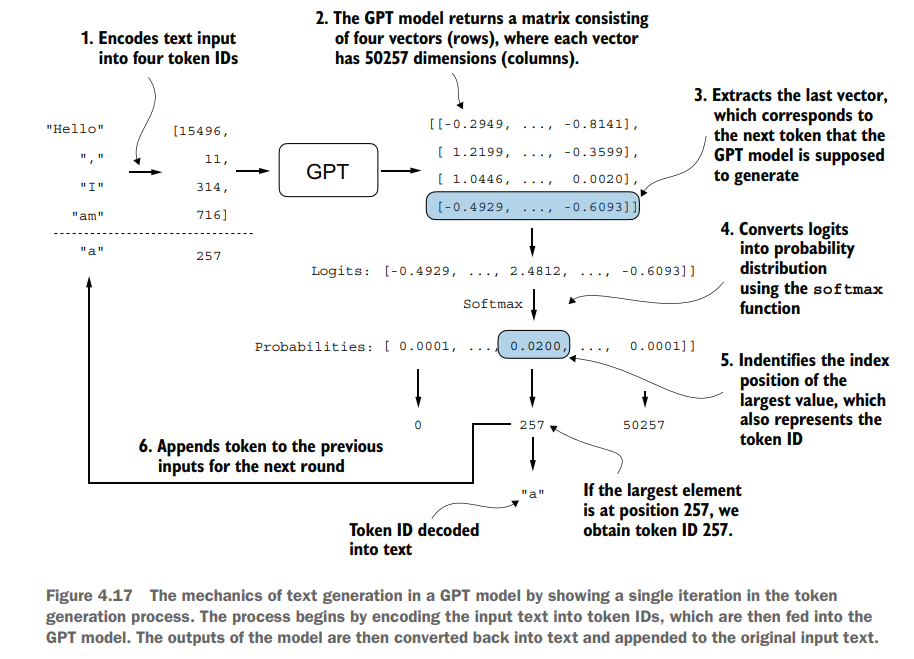

In [ ]:
# converting the numbers into text

def generate_text_simple(model,idx,
                         max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim = -1)
    idx_next = torch.argmax(probas, dim = -1, keepdim = True)
    idx = torch.cat((idx, idx_next), dim = -1)

  return idx

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M['context_length']
)
print("Output:", out)
print("Output length", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 12585, 14344,  9859, 35413]])
Output length 10


In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
decoded_text

'Hello, I am Featureiman Juerving drew complied'

As you can see this is gibbereish because the model is not yet trained.